# UnRel Dataset

This notebook converts the UnRel annotations from Matlab to python-compatible

In [1]:
import os
import sys
import json
from pathlib import Path
package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import random
random.seed(42)

from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns

data = loadmat("../data/UnRel/annotations.mat", squeeze_me=True)
data.keys()

anns = data['annotations']
anns[0].dtype

dtype([('filename', 'O'), ('im_id', 'O'), ('relationships', 'O'), ('objects', 'O')])

In [2]:
def get_anno_for_image(item):
    filename = item['filename'].item()
    im_id = item['im_id'].item()
    objects = item['objects'].item()

    bboxes = []
    for obj in objects:
        cat = obj['category'].item()
        box = obj['box'].item()
        bboxes.append({
            "category": cat,
            "bbox": box
        })

    return {
        "filename": filename,
        "img_id": im_id,
        "annotations": bboxes
    }


In [3]:
dataset = []
for item in anns:
    dataset.append(get_anno_for_image(item))

**Show a random sample in the dataset with annotations**

../data/UnRel/images/2.jpg
[ 610  534  888 1000]
[383 355 803 710]


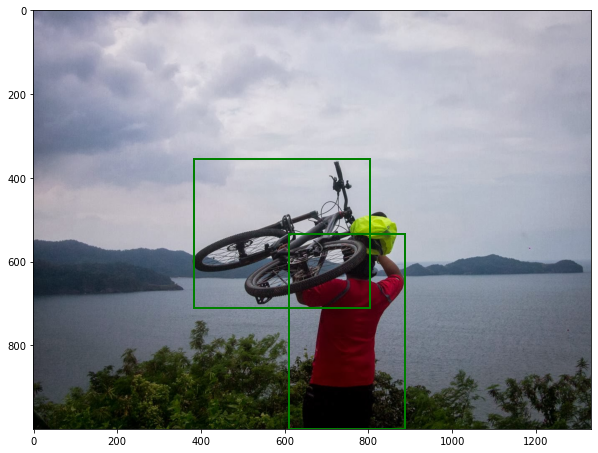

In [33]:
# sample = random.choice(dataset)
sample = list(filter(lambda x: x['img_id'] == 2, dataset))[0]

# img_path = f"../data/UnRel/images/{sample['filename']}"
img_path = f"../data/UnRel/images/2.jpg"
print(img_path)
img = Image.open(img_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)

annos = sample['annotations']
for ann in annos:
    xmin, ymin, xmax, ymax = ann['bbox']
    print(ann['bbox'])
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='g', linewidth=2)
    ax.add_artist(rect)

plt.show() 

**Annotations statistics**

In [5]:
# How many categories are there?
categories = dict()

for item in dataset:
    for ann in item['annotations']:
        cat = ann['category']
        if cat not in categories:
            categories[cat] = 1
        else:
            categories[cat] += 1

print(len(categories.keys()), categories.keys())

48 dict_keys(['person', 'bike', 'building', 'wheel', 'car', 'road', 'tree', 'bus', 'truck', 'elephant', 'dog', 'cat', 'skateboard', 'horse', 'tie', 'hat', 'cone', 'shoes', 'sunglasses', 'shirt', 'helmet', 'motorcycle', 'pants', 'jacket', 'umbrella', 'glasses', 'sofa', 'chair', 'table', 'bed', 'refrigerator', 'traffic light', 'boat', 'giraffe', 'suitcase', 'cart', 'bench', 'plane', 'box', 'trees', 'train', 'watch', 'ball', 'roof', 'surfboard', 'coat', 'bag', 'phone'])


In [6]:
df = pd.DataFrame.from_dict(categories, orient='index')
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'category', 0: 'obj_count'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   48 non-null     object
 1   obj_count  48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


Text(0.5, 1.0, 'Distribution of 48 categories in UnRel')

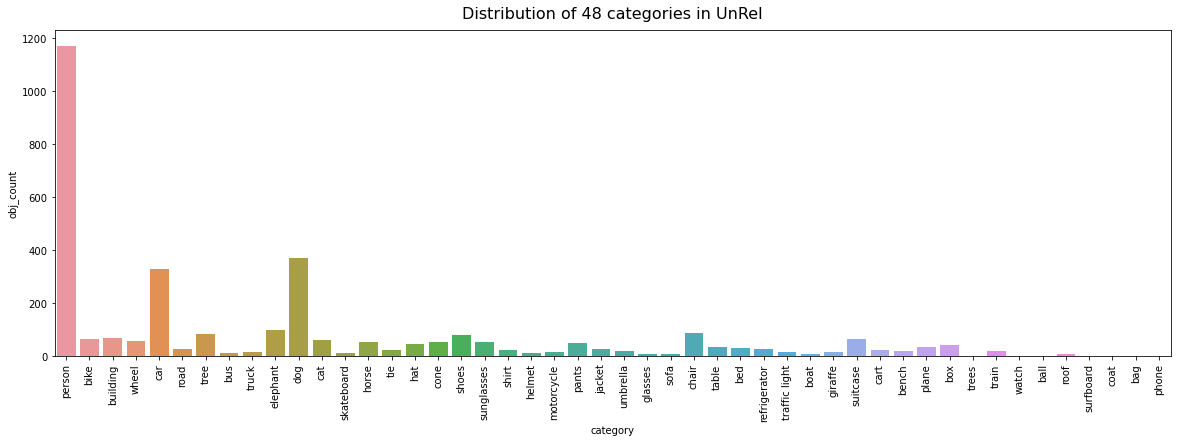

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=df, x='category', y='obj_count', ax=ax)
ax.tick_params(axis='x', labelrotation = 90)
ax.set_title(f"Distribution of {len(categories.keys())} categories in UnRel", fontsize=16, pad=12)

## Convert to COCO-like annotation format

In [8]:
coco_path = Path(package_root) / "data" / "COCO" / "val2017"

# Load coco annotation
with open(coco_path.parent / "annotations" / "instances_val2017.json") as f:
    coco_annos = json.load(f)

coco_annos.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [9]:
coco_annos['annotations'][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [10]:
coco_annos['images'][0].keys()

dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

In [11]:
coco_annos['categories'][0].keys()

dict_keys(['supercategory', 'id', 'name'])

**Create UnRel categories list**

In [12]:
unrel_categories = []
for idx, (k, v) in enumerate(categories.items()):
    unrel_categories.append({'id': idx + 1, 'name': k})

cat2idx = dict()
for item in unrel_categories:
    cat2idx[item['name']] = item['id']
unrel_categories[10]

{'id': 11, 'name': 'dog'}

**Create UnRel images list**

In [13]:
unrel_images = []
for item in dataset:
    filename = item['filename']
    file_path = f"../data/UnRel/images/{item['filename']}"
    img = Image.open(file_path)
    (width, height) = img.size
    
    image = dict(id=item['img_id'], file_name=filename, width=int(width), height=(height))
    unrel_images.append(image)

unrel_images[9]

{'id': 10, 'file_name': '10.jpg', 'width': 376, 'height': 595}

**Create UnRel annotations**

In [36]:
['iscrowd', 'image_id', 'bbox', 'category_id', 'id']

unrel_annotations = []
anno_idx = 0
for item in dataset:
    image_id = int(item['img_id'])
    iscrowd = 0
    for ann in item['annotations']:
        category_id = cat2idx[ann['category']]
        xmin, ymin, xmax, ymax = ann['bbox']
        w = xmax - xmin
        h = ymax - ymin

        bbox = [int(xmin), int(ymin), int(w), int(h)]

        unrel_ann = dict(id=anno_idx, category_id=category_id, bbox=bbox, image_id=image_id, iscrowd=iscrowd)
        unrel_annotations.append(unrel_ann)

        anno_idx += 1

len(unrel_annotations)

3309

In [37]:
unrel_data = {
    "images": unrel_images,
    "categories": unrel_categories,
    "annotations": unrel_annotations
}

with open("../data/UnRel/instances_unrel.json", "w") as f:
    json.dump(unrel_data, f)

In [38]:
list(filter(lambda x: x['image_id'] == 2, unrel_annotations))

[{'id': 2,
  'category_id': 1,
  'bbox': [610, 534, 278, 466],
  'image_id': 2,
  'iscrowd': 0},
 {'id': 3,
  'category_id': 2,
  'bbox': [383, 355, 420, 355],
  'image_id': 2,
  'iscrowd': 0}]

In [39]:
unrel_data.keys()

dict_keys(['images', 'categories', 'annotations'])

**Test if the annotations work with CocoDetection**

In [40]:
from sparse_detector.datasets.coco import CocoDetection

In [41]:
unrel_path = coco_path.parent.parent / "UnRel"
img_folder = unrel_path / "images"
ann_file = unrel_path / "instances_unrel.json"

coco = CocoDetection(img_folder, ann_file, transforms=None)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [42]:
sample = coco[1]

In [43]:
img = sample[0]
anno = sample[1]

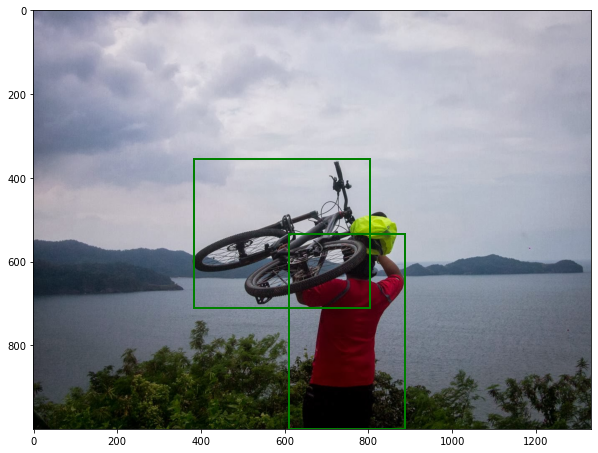

In [46]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(img)
boxes = anno['boxes'].detach().cpu().tolist()

for box in boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='g', linewidth=2)
    ax.add_artist(rect)

plt.show()

In [28]:
bbox = anno['boxes'].detach().cpu().tolist()
bbox

[[66.0, 91.0, 435.0, 192.0], [66.0, 91.0, 435.0, 192.0]]

In [25]:
anno

{'boxes': tensor([[ 66.,  91., 435., 192.],
         [ 66.,  91., 435., 192.]]),
 'labels': tensor([44, 44]),
 'image_id': tensor([2]),
 'area': tensor([0., 0.]),
 'iscrowd': tensor([0, 0]),
 'orig_size': tensor([1000, 1333]),
 'size': tensor([1000, 1333])}

## Show a sample from original COCO

In [47]:
img_folder = coco_path
ann_file = coco_path.parent / "annotations" / "instances_val2017.json"

coco_2 = CocoDetection(img_folder, ann_file, transforms=None)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [51]:
coco_2[3]

(<PIL.Image.Image image mode=RGB size=375x500 at 0x1459F3B18850>,
 {'boxes': tensor([[120.0700,  71.8300, 254.5600, 224.9100],
          [123.3900, 279.4400, 145.1300, 309.6100],
          [128.2600, 267.2100, 141.1400, 275.3600],
          [202.3800, 259.9000, 221.3900, 285.9600]]),
  'labels': tensor([13,  8,  3, 13]),
  'image_id': tensor([724]),
  'area': tensor([16433.5801,   418.0800,    79.6036,   327.1696]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'orig_size': tensor([500, 375]),
  'size': tensor([500, 375])})

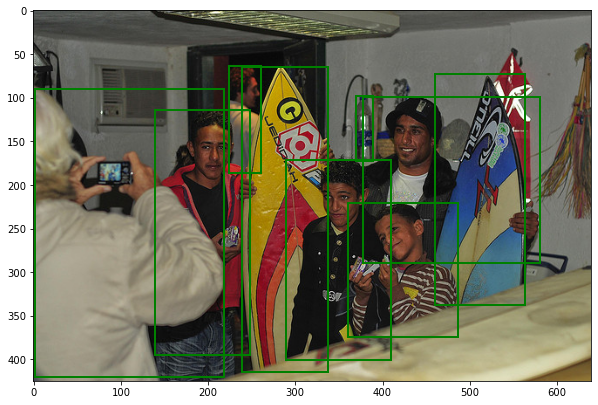

In [56]:
img, anno = coco_2[50]
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(img)
boxes = anno['boxes'].detach().cpu().tolist()

for box in boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='g', linewidth=2)
    ax.add_artist(rect)

plt.show()